# Optical character recognition (OCR)


In [26]:
#!pip install easyocr

Saving catchme_1_0.jpg to catchme_1_0 (2).jpg


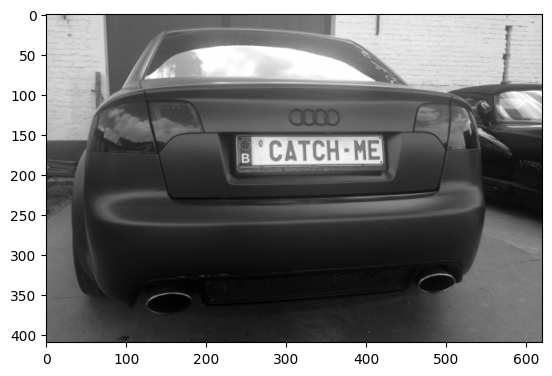

In [13]:
# Import necessary libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import easyocr

# For file upload in Colab
from google.colab import files
uploaded = files.upload()

# Extract the filename of the uploaded image
filename = list(uploaded.keys())[0]

# Read and convert the image to grayscale
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray'


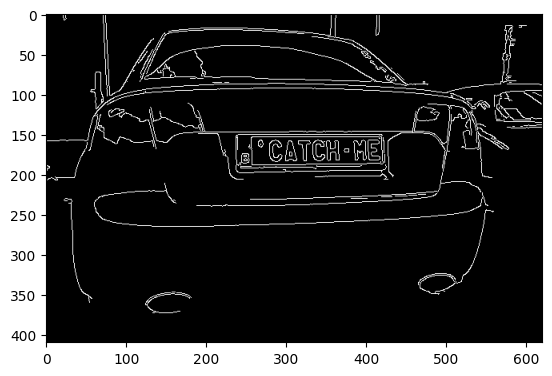

In [15]:
# Apply bilateral filter to reduce noise while keeping edges sharp
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

# Detect edges using the Canny algorithm
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(edged, cmap='gray')


In [16]:
# Find contours from the edged image
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contourss = imutils.grab_contours(keypoints)

# Sort contours by area and keep only the largest ones
contours = sorted(contourss, key=cv2.contourArea, reverse=True)[:10]
#print(contours)
len(contours)

10

In [17]:
# Attempt to find a rectangular contour that could be the plate
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:  # Looking for a quadrilateral
        location = approx
        break

len(location)

4

In [18]:
location

array([[[419, 154]],

       [[420, 187]],

       [[257, 187]],

       [[258, 153]]], dtype=int32)

In [19]:
approx[1][0][0]

np.int32(420)

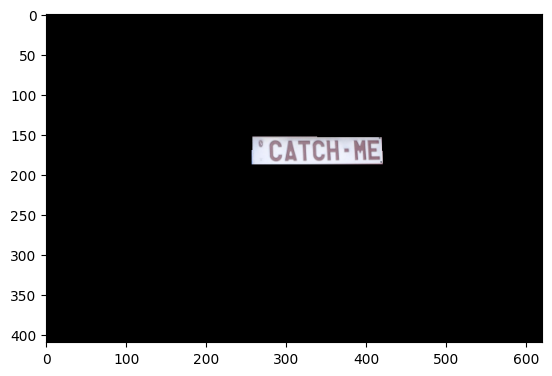

In [21]:
# Create a mask and draw the detected license plate on it
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], -1, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

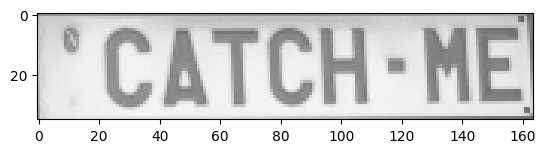

In [23]:
# Crop the region of interest (presumed plate) from the image
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [24]:
# Use EasyOCR to read text from the cropped license plate
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[([[np.int32(19), np.int32(1)],
   [164, np.int32(1)],
   [164, 35],
   [np.int32(19), 35]],
  'Catch-ME',
  np.float64(0.3634849656483746))]

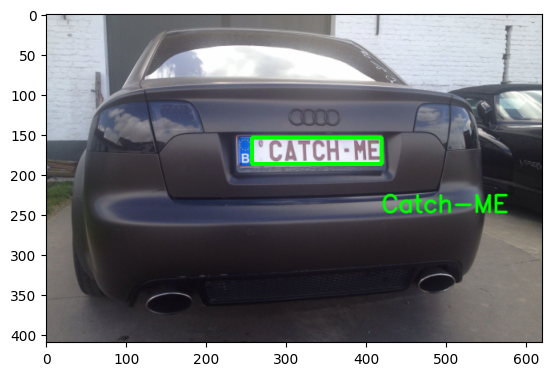

In [25]:
# Extract text and annotate the original image
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60),
                  fontFace=font, fontScale=1, color=(0,255,0),
                  thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0), 3)

# Display the final image with the detected plate and text
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))